In [1]:
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt
from time import sleep
from matplotlib.patches import Circle

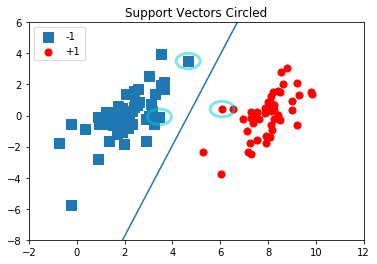

In [11]:
# 查看测试数据，并给出一个 分割线，直观的理解一下 支持向量
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
fr = open('testSet.txt')#this file was generated by 2normalGen.py
for line in fr.readlines():
    lineSplit = line.strip().split('\t')
    xPt = float(lineSplit[0])
    yPt = float(lineSplit[1])
    label = int(lineSplit[2])
    if (label < 0):
        xcord0.append(xPt)
        ycord0.append(yPt)
    else:
        xcord1.append(xPt)
        ycord1.append(yPt)

fr.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90, label = '-1')
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red', label = '+1')
plt.title('Support Vectors Circled')
circle = Circle((4.6581910000000004, 3.507396), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((3.4570959999999999, -0.082215999999999997), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
circle = Circle((6.0805730000000002, 0.41888599999999998), 0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)
#plt.plot([2.3,8.5], [-6,6]) #seperating hyperplane
b = -3.75567; w0=0.8065; w1=-0.2761
x = np.arange(-2.0, 12.0, 0.1)
y = (-w0*x - b)/w1
ax.plot(x,y)
ax.axis([-2,12,-8,6])
plt.legend(loc = 'upper left')
plt.show()

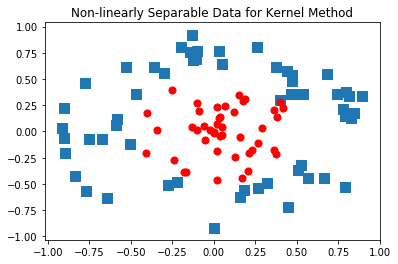

In [3]:
# 生成测试数据
fw = open('testSetRBF2.txt', 'w')#generate data
fig = plt.figure()
ax = fig.add_subplot(111)
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
for i in range(100):
    [x,y] = np.random.uniform(0,1,2)
    xpt=x*np.cos(2.0*np.pi*y); ypt = x*np.sin(2.0*np.pi*y)
    if (x > 0.5):
        xcord0.append(xpt); ycord0.append(ypt)
        label = -1.0
    else:
        xcord1.append(xpt); ycord1.append(ypt)
        label = 1.0
    fw.write('%f\t%f\t%f\n' % (xpt, ypt, label))
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Non-linearly Separable Data for Kernel Method')
plt.show()
fw.close()
